# Fit the multiple-reactivation model to early-treated macaque data

In this notebook, we...

1. import the data using `pickle`
2. compile the Stan models
3. convert the data into a format that can be interpreted by the Stan models
4. run the Stan models
5. Extract data and create figures
6. Compute WAIC
7. Export some of the estimates for use in other notebooks

Many of these operations are quite simple, but require a lot of boilerplate code

**/!\ WARNING /!\** The Stan models use the symbol `r` instead of $g$ for the exponential growth rate.

In [1]:
import pickle
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pystan
import sys
import os
import scipy.stats as sts

sys.path.append("..")
from mrmpytools import definitions as defn
from mrmpytools import utilities as util
from mrmpytools import plots
from mrmpytools.pystantools import cachedStanModel, calcWAIC, approximate_mode

In [2]:
plt.rcParams.update({'font.size': 18})

## 1. Import the data

The "pickle" is created in the notebook `ParseData.ipynb`.
So **run this notebook first** if you haven't alreasy.

In [3]:
pickle_name = os.path.join("..", "data", "rebound-data.pkl")
with open(pickle_name, 'rb') as f:
    data_dicts = pickle.load(f)
    
IDs = sorted(data_dicts.keys())

### Put some of the data in separate dictionaries

In particular, we want to exclue data points that are not consistent with the simple logistic growth model. For this, we have manually selected time points `MaxTime` beyond which data is excluded for each macaque.

In [4]:
txsdict = {} ## contains the timeseries
startartdict = {} ## contains StartART value
SIDdict = {} ## contains the study ID
maxtimedict = {} ## contains the MaxTime time point

for ID in IDs:
    dd = data_dicts[ID]
    txsdict[ID] = [(t, VL, CC) for t, VL, CC in zip(dd["t"], dd["VL"], dd["CC"])]
    startartdict[ID] = dd["StartART"]
    SIDdict[ID] = dd["SID"]
    maxtimedict[ID] = dd["MaxTime"]

## remove time points after manually selected MaxTime
shorttxsdict = {
    ID : [tx for tx in txsdict[ID] if maxtimedict[ID] >= tx[0]]
    for ID in txsdict.keys()
}

## 2. Compile the Stan models

To avoid recompilation, we use the `cachedStanModel` function
imported from `mrmpytools.pystantools`. See also the example in the `pystan`
[documentation](https://pystan.readthedocs.io/en/latest/avoiding_recompilation.html).
The pystan models are pickled and stored in the `stan-models/cache` directory.
We first create this folder if it does not exist.

**This may take some time!** but if you don't change the models, this is only required once.

In [5]:
## make a cache directory for the stan models to avoir re-compiling
cache_dir = os.path.join("..", "stan-models", "cache")
try:
    os.mkdir(cache_dir)
    print("created stan cache directory")
except FileExistsError:
    pass

stan_file_MRM_II = "logistic-rebound-model-multiple-reactiv-II.stan"
stan_file_SRM = "logistic-rebound-model-single-reactiv.stan"
stan_file_MRM_CD = "logistic-rebound-model-multiple-reactiv-CD.stan"

stan_dir = os.path.join("..", "stan-models")


with open(os.path.join(stan_dir, stan_file_MRM_II), 'r') as f:
    sm_MRM_II = cachedStanModel(model_code=f.read(), model_name="MRM_II", work_dir=cache_dir)
    
with open(os.path.join(stan_dir, stan_file_SRM), 'r') as f:
    sm_SRM = cachedStanModel(model_code=f.read(), model_name="SRM", work_dir=cache_dir)

with open(os.path.join(stan_dir, stan_file_MRM_CD), 'r') as f:
    sm_MRM_CD = cachedStanModel(model_code=f.read(), model_name="MRM_CD", work_dir=cache_dir)

Using cached StanModel
Using cached StanModel
Using cached StanModel


## 3. Convert the data into a Stan-readable format

The Stan models have a `data` block listing all the required data.
Currently, these is no rugged data structure in Stan, but all our subjects have a different number of data points. Therefore, we have to apply "padding".

We also define some constants, like the limit of detection for this study, and some values for hyper-parameters. The number of simulated time points `NumSimTimePts` is used to plot trajectories of the logistic growth model for the VL.

By default, we use a drug-washout time of $0$ days, but this can be adjusted by setting the variable `DrugDelay` to e.g. $1$ day.

Default initial parameter value sampling does not work well for our models. Therefore we supply initial guesses that are more reasonable.

In [6]:
DetectionLimit = 5e1
NumSimTimePts = 100

## use both Withney early ART studies
SIDs = ['15-11', '13-08']

## make sure that the IDs are sorted by ART init time
IDs.sort(key=lambda x: startartdict[x])

NumTimePts = [len(shorttxsdict[ID]) for ID in IDs]
zpadding = [[0 for _ in range(max(NumTimePts) - n)] for n in NumTimePts]
cpadding = [[defn.missing_code for _ in range(max(NumTimePts) - n)] for n in NumTimePts]

TimePts = [[x[0] for x in shorttxsdict[ID]] + pad for ID, pad in zip(IDs, zpadding)]
VirusLoad = [[x[1] for x in shorttxsdict[ID]] + pad for ID, pad in zip(IDs, zpadding)]
CensorCode = [[x[2] for x in shorttxsdict[ID]] + pad for ID, pad in zip(IDs, cpadding)]

DrugDelay = 0.0
MaxLogVZero = np.log(DetectionLimit)

PriorMeanSigma = 0.0 
PriorSdSigma = 0.5

## The keys correspond with names in the Stan models

data_dict = {
    "NumSubjects" : len(IDs),
    "NumTimePts" : NumTimePts,
    "TimePts" : TimePts,
    "NumSimTimePts" : NumSimTimePts,
    "VirusLoad" : VirusLoad,
    "CensorCode" : CensorCode,
    "StartART" : [startartdict[ID] for ID in IDs],
    "DetectionLimit" : DetectionLimit,
    "PriorMeanLogK" : 5 * np.log(10),
    "PriorSdLogK" : 2 * np.log(10),
    "PriorMeanLogR" : 0.0,
    "PriorSdLogR" : 1.0,
    "PriorMeanAlphaLogR" : 0.0,
    "PriorSdAlphaLogR" : 1.0,
    "MaxR" : 4.0,
    "PriorMeanSigma" : PriorMeanSigma,
    "PriorSdSigma" : PriorSdSigma,
    ## hyper parameters for the reactivation model
    "PriorMeanLogLambda" : 0.0,
    "PriorSdLogLambda" : 1.0,
    "PriorMeanLogVZero" : -1.0,
    "PriorSdLogVZero" : 1.0,
    "MaxLogVZero" : MaxLogVZero,
    "PriorMeanAlphaLogLambda" : 0.0,
    "PriorSdAlphaLogLambda" : 1.0,
    ## Drug washout delay
    "DrugDelay" : DrugDelay
}

def gen_init_dict():
    """
    This function is called once for each chain by pystan.
    The keys of the dictionary correspond with parameter 
    names of the Stan models.
    """
    return {
        "logK" : [5 * np.log(10) for _ in IDs],
        "logr" : [0 for _ in IDs],
        "sigma" : PriorMeanSigma + PriorSdSigma,
        "mu_logr" : 0,
        "sigma_logr" : 1.0,
        "alpha_logr" : 0.0,
        "mu_logK" : 5 * np.log(10),
        "sigma_logK" : 2 * np.log(10),
        ## initial values for the reavtivation model
        "loglambda" : [0.0 for _ in IDs],
        "mu_loglambda" : 0.0,
        "sd_loglambda" : 1.0,
        "alpha_loglambda" : 0.0,
        "logv0" : -1.0,
        "fstReactivTime" : [1.0 for _ in IDs],
        "relativeReboundTime" : [9.0 for _ in IDs],
    }

## 4. Run the Stan models

We have to tweak Stan's algorithmic parameters a bit to avoid divergence of the HMC algorithm.
To get a better estimate of the WAIC below, we can repeat the sampling a number of times (set `dups` > 1).

**This may take a lot of time!** But doing a single run with 2000 iterations is relatively fast.

In [7]:
control_dict = {
    "adapt_delta" : 0.99,
    "max_treedepth" : 20
}

kwargs = {
    "data" : data_dict,
    "init" : gen_init_dict,
    "iter" : 2000, ## 10000
    "chains" : 1, ## 4
    "thin" : 1, ## 20
    "control" : control_dict,
    "refresh" : 10
}

## number of duplicate runs for SEM estimation of WAIC
dups = 1

## run MCMCs
sams_MRM_II = [sm_MRM_II.sampling(**kwargs) for _ in range(dups)]
sams_MRM_CD = [sm_MRM_CD.sampling(**kwargs) for _ in range(dups)]
sams_SRM = [sm_SRM.sampling(**kwargs) for _ in range(dups)]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [8]:
## check diagnostics...
diags = pystan.check_hmc_diagnostics(sams_MRM_II[0])
print(diags['Rhat'])

True


## 5. Create figures and compute some statistics

First, we have to select one of the chains.

In [9]:
chain = sams_MRM_II[0].extract(permuted=True)

### Compute posterior probabilities of the effect of ART initiation

P[alpha_g >= 0] = 0.0
P[alpha_lambda <= 0] = 0.0
minimal resolution = 0.001


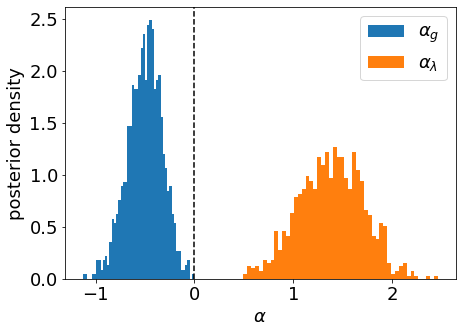

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

ax1.hist(chain["alpha_logr"], 50, density=True, label="$\\alpha_g$")
ax1.hist(chain["alpha_loglambda"], 50, density=True, label="$\\alpha_{\\lambda}$")

ax1.set_xlabel('$\\alpha$')
ax1.legend()
ax1.set_ylabel("posterior density")

ax1.axvline(x=0, color='k', linestyle='--')

alphalogrs = chain["alpha_logr"]

PrAlphaG = len([x for x in alphalogrs if x >= 0]) / len(alphalogrs)

print("P[alpha_g >= 0] =", PrAlphaG)

alphaloglambdas = chain["alpha_loglambda"]

PrAlphaLam = len([x for x in alphaloglambdas if x <= 0]) / len(alphaloglambdas)

print("P[alpha_lambda <= 0] =", PrAlphaLam)

print("minimal resolution =", 1/len(chain["alpha_loglambda"]))

### Express the effect of treatment initiation time as a percentage change per day of the growth rate $g$

$$
g = \exp(\epsilon_{g} + t_{\rm ART}^* \alpha_{g})
$$

In [12]:
sdStartART = np.std([startartdict[ID] for ID in IDs])
phi_r = approximate_mode(np.exp(chain["alpha_logr"]/sdStartART))
phi_r_Q1 = np.percentile(np.exp(chain["alpha_logr"]/sdStartART), 25)
phi_r_Q3 = np.percentile(np.exp(chain["alpha_logr"]/sdStartART), 75)
print(f"phi = {phi_r:0.2f} (50% CrI: [{phi_r_Q1:0.2f}, {phi_r_Q3:0.2f}])")
print(f"1 - phi = {1-phi_r:0.2f} (50% CrI: [{1-phi_r_Q3:0.2f}, {1-phi_r_Q1:0.2f}])")

phi = 0.90 (50% CrI: [0.87, 0.92])
1 - phi = 0.10 (50% CrI: [0.08, 0.13])


### Express the effect of treatment initiation time as a percentage change per day of the recrudescence rate $\lambda$
 

As $\lambda = \exp(\epsilon_{\lambda} + t_{\rm ART}^* \alpha_{\lambda})$, the reactivation rate
doubles each $x$ days, where $x = $...

In [13]:
sdStartART = np.std([startartdict[ID] for ID in IDs])
phi_lambda = approximate_mode(np.exp(chain["alpha_loglambda"]/sdStartART))
phi_lambda_Q1 = np.percentile(np.exp(chain["alpha_loglambda"]/sdStartART), 25)
phi_lambda_Q3 = np.percentile(np.exp(chain["alpha_loglambda"]/sdStartART), 75)
phi_lambda_low = np.percentile(np.exp(chain["alpha_loglambda"]/sdStartART), 2.5)
phi_lambda_high = np.percentile(np.exp(chain["alpha_loglambda"]/sdStartART), 97.5)
print(f"phi = {phi_lambda:0.2f} (50% CrI: [{phi_lambda_Q1:0.2f}, {phi_lambda_Q3:0.2f}])")
print(f"phi - 1 = {phi_lambda-1:0.2f} (50% CrI: [{phi_lambda_Q1-1:0.2f}, {phi_lambda_Q3-1:0.2f}])")
print(f"phi = {phi_lambda:0.2f} (95% CrI: [{phi_lambda_low:0.2f}, {phi_lambda_high:0.2f}])")
print(f"phi - 1 = {phi_lambda-1:0.2f} (95% CrI: [{phi_lambda_low-1:0.2f}, {phi_lambda_high-1:0.2f}])")

phi = 1.37 (50% CrI: [1.30, 1.45])
phi - 1 = 0.37 (50% CrI: [0.30, 0.45])
phi = 1.37 (95% CrI: [1.18, 1.57])
phi - 1 = 0.37 (95% CrI: [0.18, 0.57])


### Figure S1

Fits for the model to all subjects

Text(0.5, 0.05, 'time post treatment interruption (days)')

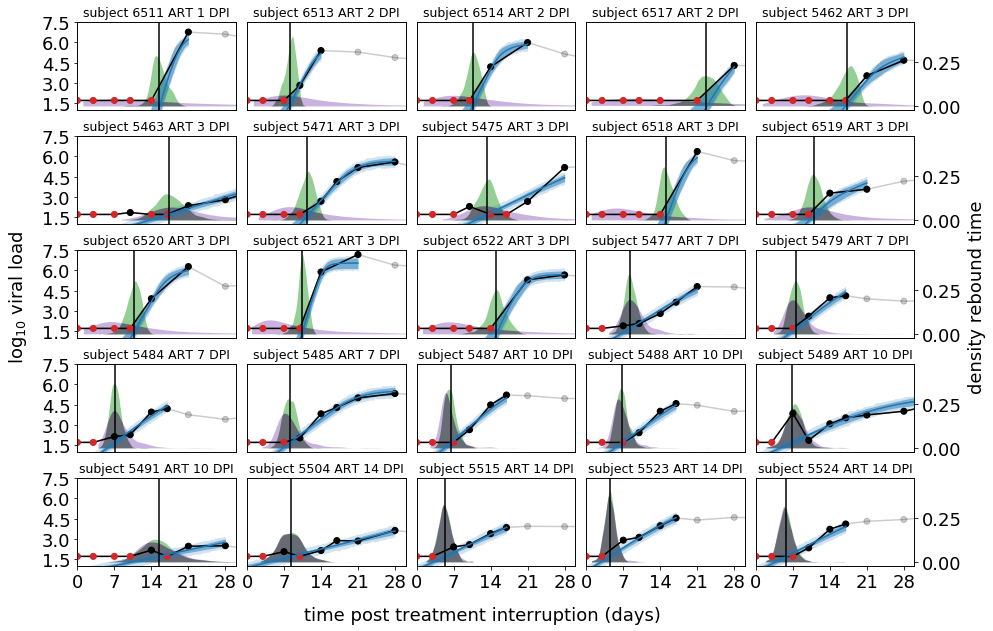

In [14]:
#PlotCndlReboundDistr = False
PlotCndlReboundDistr = True

cols = 5
rows = len(IDs) // cols + (0 if len(IDs) % cols == 0 else 1)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(rows, cols)
gs.update(wspace=0.07, hspace=0.3)

bxs = []

for i, ID in enumerate(IDs):
    col = i % cols
    row = i // cols
    ax = fig.add_subplot(gs[row, col])
    ## plot all rebound data on background
    ts, VLs, CCs = util.unzip(txsdict[ID])
    logVLs = np.log(VLs) / np.log(10)
    ax.plot(ts, logVLs, zorder=1, color='k', alpha=0.2)
    colors = ['k' if CC == defn.uncensored_code else 'tab:red' for CC in CCs]
    ax.scatter(ts, logVLs, color=colors, zorder=1, alpha=0.2)
    ## plot the data used for fitting on foreground
    ts, VLs, CCs = util.unzip(shorttxsdict[ID])
    logVLs = np.log(VLs) / np.log(10)
    ax.plot(ts, logVLs, zorder=1, color='k')
    colors = ['k' if CC == defn.uncensored_code else 'tab:red' for CC in CCs]
    ax.scatter(ts, logVLs, color=colors, zorder=2)
    ax.set_title(f"subject {ID} ART {str(startartdict[ID])} DPI", fontsize='x-small')
    ## add model predictions
    logVLhats = chain["logVLhat"][:, i, :].T / np.log(10)
    meanLogVLhats = [np.mean(xs) for xs in logVLhats]
    qsLogVLhats = [np.percentile(xs, [25, 75]) for xs in logVLhats]
    logVLsims = chain["logVLsim"][:, i, :].T / np.log(10)
    qsLogVLsims = [np.percentile(xs, [25, 75]) for xs in logVLsims]
    tts = np.linspace(0, np.max(ts), NumSimTimePts, endpoint=True)
    ax.plot(tts, meanLogVLhats, color='tab:blue')
    ax.fill_between(tts, [q[0] for q in qsLogVLhats], [q[1] for q in qsLogVLhats], 
                    color='tab:blue', alpha=0.5, linewidth=0)
    ax.fill_between(tts, [q[0] for q in qsLogVLsims], [q[1] for q in qsLogVLsims], 
                    color='tab:blue', alpha=0.2, linewidth=0)
    ax.set_ylim(1, 7.5)
    ax.set_yticks(np.linspace(1.5, 7.5, 5))
    ## plot rebound times
    reboundTime = chain["reboundTime"][:,i]
    meanReboundTime = np.mean(reboundTime)
    qsReboundTime = np.percentile(reboundTime, [25, 75])
    ax.axvline(x=meanReboundTime, color='k')
    bx = ax.twinx()
    ## make a histogram from simulated rebound times 
    sims = [x for x in chain["timeToReboundsim"][:,i] if not np.isnan(x)]
    kde = sts.gaussian_kde(sims)
    xs = np.linspace(np.min(sims), np.max(sims), 500)
    ys = kde(xs)
    bx.fill_between(xs, ys, color='tab:purple', alpha=0.5, linewidth=0, zorder=2)
    bx.set_yticks(np.linspace(0.0, 0.5, 3))
    if PlotCndlReboundDistr:
        ## make a histogram from simulated rebound times conditioned on the first reactivation
        sims = [x for x in chain["timeToReboundsimCndlFstReactiv"][:,i] if not np.isnan(x)]
        kde = sts.gaussian_kde(sims)
        ys_cndl = kde(xs) ## use same xs as above
        bx.fill_between(xs, ys_cndl, color='tab:green', alpha=0.5, linewidth=0, zorder=1)
        overlap = [min(y, y_cndl) for y, y_cndl in zip(ys, ys_cndl)]
        bx.fill_between(xs, overlap, color='k', alpha=0.3, linewidth=0, zorder=3)
    ## add bs to list to share y-scale
    bxs.append(bx)
    ## zoom in
    ax.set_xlim(0, 30)
    ax.set_xticks(range(0, 30, 7))
    ## remove repeated axes
    if col > 0:
        ax.get_yaxis().set_visible(False)
    if col < cols-1:
        bx.get_yaxis().set_visible(False)
    if row < rows-1:
        ax.get_xaxis().set_visible(False)
    ## move the distributions to the background (as twinx puts them in the foreground)
    ax.set_zorder(bx.get_zorder()+1) # put ax in front of bx
    ax.patch.set_visible(False) # hide the 'canvas' 

bxs[0].get_shared_y_axes().join(*bxs)
bxs[0].autoscale(axis='y')
    
fig.text(0.06, 0.5, "$\\log_{10}$ viral load", va='center', rotation=90)
fig.text(0.95, 0.5, "density rebound time", va='center', rotation=90)
fig.text(0.5, 0.05, "time post treatment interruption (days)", ha='center')
    
#fig.savefig("../FigureS1.pdf", bbox_inches='tight')

### Is $\tau$ contained in the 95% CrIs of the PPDs?

In [15]:
failed95 = []
failed50 = []

for i, ID in enumerate(IDs):
    reboundTime = chain["reboundTime"][:,i]
    meanReboundTime = np.mean(reboundTime)
    sims = [x for x in chain["timeToReboundsim"][:,i] if not np.isnan(x)]
    ## 95 % CrI
    tlow, thigh = np.percentile(sims, [2.5, 97.5])
    if meanReboundTime <= tlow or meanReboundTime >= thigh:
        failed95.append(ID)
    ## 50% CrI
    tlow, thigh = np.percentile(sims, [25, 75])
    if meanReboundTime <= tlow or meanReboundTime >= thigh:
        failed50.append(ID)
        
print("95% failed:", len(failed95), " / ", len(IDs))
print("50% failed:", len(failed50), " / ", len(IDs))

95% failed: 0  /  25
50% failed: 4  /  25


### Figure S2

Plot $T_1$ and $\widehat{T}_1$

(50, 1000)


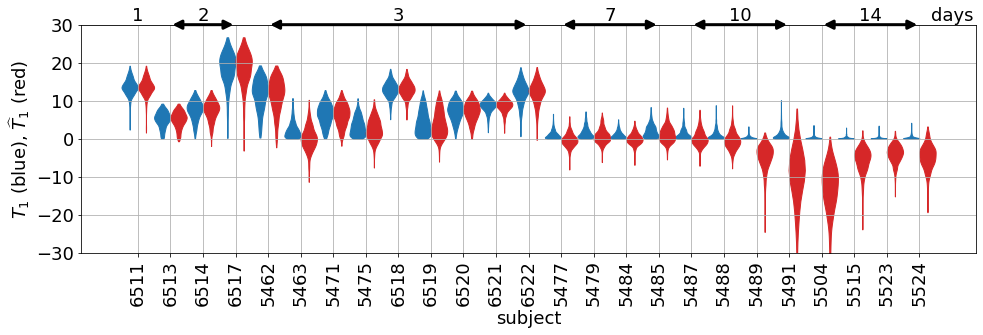

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,5), sharex=True)

T1s = chain["fstReactivTime"]
t0s = chain["extrapolatedFstReactivTime"]

talls = np.concatenate([T1s.T, t0s.T])
print(talls.shape)
midpos = np.array(range(len(IDs)))
pos = np.concatenate([midpos-0.25, midpos+0.25])

vps = ax1.violinplot(talls.T, positions=pos, showextrema=False)
for i, vp in enumerate(vps['bodies']):
    if i < len(IDs):
        vp.set_facecolor("tab:blue")
        vp.set_edgecolor("tab:blue")
    else:
        vp.set_facecolor("tab:red")
        vp.set_edgecolor("tab:red")
    vp.set_linewidth(1)
    vp.set_alpha(1)    


## other labels
    
ax1.set_ylabel("$T_1$ (blue), $\\widehat{T}_1$ (red)")
ax1.grid()

ax1.set_xticks(range(len(IDs)))
ax1.set_xticklabels(IDs, rotation=90)
        
ax1.set_xlabel("subject")

ax1.set_ylim(-30,30)

## add ART starting days to figure

ARTStartDays = [startartdict[ID] for ID in IDs]    
ARTStartDayIdxRanges = []
for i, x in enumerate(ARTStartDays):
    if len(ARTStartDayIdxRanges) == 0 or ARTStartDayIdxRanges[-1][1] != x:
        ARTStartDayIdxRanges.append((i,x))
ARTStartDayIdxRanges.append((len(ARTStartDays), None))

for ix1, ix2 in zip(ARTStartDayIdxRanges[:-1], ARTStartDayIdxRanges[1:]):
    i1, i2 = ix1[0], ix2[0]-1
    xpos = 0.5 * (i2 + i1)
    ypos = ax1.get_ylim()[1]
    x = ix1[1]
    ax1.text(xpos, ypos, str(x), va='bottom', ha='center')
    ax1.annotate("", xy=(i1, ypos), xytext=(i2, ypos), 
                 arrowprops=dict(arrowstyle="<|-|>", facecolor='black', linewidth=3))

xpos = len(IDs)
ypos = ax1.get_ylim()[1]
ax1.text(xpos, ypos, "days", va='bottom', ha='center')


fig.tight_layout()
    
#fig.savefig("../FigureS2.pdf", bbox_inches='tight')

### Figure 3

Example fits for the main text

Text(0.8, 0.3, 'u')

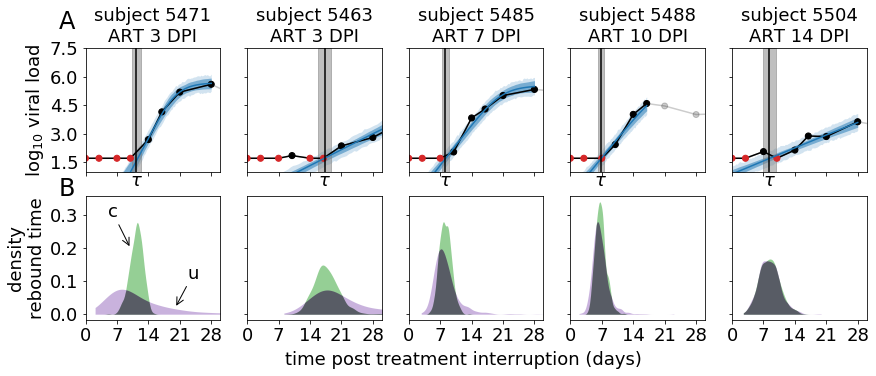

In [17]:
repres_IDs = ['5471', '5463', '5485', '5488', '5504']
repres_idxs = [dict(zip(IDs, range(len(IDs))))[k] for k in repres_IDs]

fig, axs = plt.subplots(2, len(repres_IDs), figsize=(14,5), sharex=True, sharey='row')

for j, ID in enumerate(repres_IDs):
    i = repres_idxs[j]
    ax, bx = axs[:,j]
    ## plot all rebound data on background
    ts, VLs, CCs = util.unzip(txsdict[ID])
    logVLs = np.log(VLs) / np.log(10)
    ax.plot(ts, logVLs, zorder=1, color='k', alpha=0.2)
    colors = ['k' if CC == defn.uncensored_code else 'tab:red' for CC in CCs]
    ax.scatter(ts, logVLs, color=colors, zorder=2, alpha=0.2)
    ## plot the data used for fitting on foreground
    ts, VLs, CCs = util.unzip(shorttxsdict[ID])
    logVLs = np.log(VLs) / np.log(10)
    ax.plot(ts, logVLs, zorder=1, color='k')
    colors = ['k' if CC == defn.uncensored_code else 'tab:red' for CC in CCs]
    ax.scatter(ts, logVLs, color=colors, zorder=2)
    ax.set_title(f"subject {ID}\nART {str(startartdict[ID])} DPI", fontsize=18)
    ## add model predictions
    logVLhats = chain["logVLhat"][:, i, :].T / np.log(10)
    meanLogVLhats = [np.mean(xs) for xs in logVLhats]
    qsLogVLhats = [np.percentile(xs, [25, 75]) for xs in logVLhats]
    logVLsims = chain["logVLsim"][:, i, :].T / np.log(10)
    qsLogVLsims = [np.percentile(xs, [25, 75]) for xs in logVLsims]
    tts = np.linspace(0, np.max(ts), NumSimTimePts, endpoint=True)
    ax.plot(tts, meanLogVLhats, color='tab:blue')
    ax.fill_between(tts, [q[0] for q in qsLogVLhats], [q[1] for q in qsLogVLhats], 
                    color='tab:blue', alpha=0.5, linewidth=0)
    ax.fill_between(tts, [q[0] for q in qsLogVLsims], [q[1] for q in qsLogVLsims], 
                    color='tab:blue', alpha=0.2, linewidth=0)
    ax.set_ylim(1, 7.5)
    ax.set_yticks(np.linspace(1.5, 7.5, 5))
    ## plot rebound times
    reboundTime = chain["reboundTime"][:,i]
    meanReboundTime = np.mean(reboundTime)
    qsReboundTime = np.percentile(reboundTime, [25, 75])
    ax.axvline(x=meanReboundTime, color='k')
    ax.axvspan(qsReboundTime[0], qsReboundTime[1], color='gray', alpha=0.5)
    
    ax.text(meanReboundTime, plots.ordinate_transform(ax, 0, which='y'), '$\\tau$', 
            ha='center', va='top')
    ## make a histogram from simulated rebound times 
    sims = [x for x in chain["timeToReboundsim"][:,i] if not np.isnan(x)]
    #bx.hist(sims, bins=100, density=True, alpha=0.5, color='tab:orange')
    kde = sts.gaussian_kde(sims)
    xs = np.linspace(np.min(sims), np.max(sims), 500)
    ys = kde(xs)
    bx.fill_between(xs, ys, color='tab:purple', alpha=0.5, linewidth=0, zorder=2)
    bx.set_yticks(np.linspace(0, 0.3, 4))
    if PlotCndlReboundDistr:
        ## make a histogram from simulated rebound times conditioned on the first reactivation
        sims = [x for x in chain["timeToReboundsimCndlFstReactiv"][:,i] if not np.isnan(x)]
        #bx.hist(sims, bins=100, density=True, alpha=0.5, color='tab:green')
        kde = sts.gaussian_kde(sims)
        ys_cndl = kde(xs) ## use same xs as above
        bx.fill_between(xs, ys_cndl, color='tab:green', alpha=0.5, linewidth=0, zorder=1)
        overlap = [min(y, y_cndl) for y, y_cndl in zip(ys, ys_cndl)]
        bx.fill_between(xs, overlap, color='k', alpha=0.4, linewidth=0, zorder=3)
        
        
    ## zoom in
    ax.set_xlim(0, 30)
    ax.set_xticks(range(0,30,7))
    
fig.text(0.5, 0, "time post treatment interruption (days)", ha='center')

axs[0,0].set_ylabel("$\\log_{10}$ viral load")
axs[1,0].set_ylabel("density\nrebound time")

axs[0,0].text(-0.2, 1.15, "A", fontsize=24, transform=axs[0,0].transAxes, ha='left')
axs[1,0].text(-0.2, 1.0, "B", fontsize=24, transform=axs[1,0].transAxes, ha='left')    

## manually annotate the distributions for BW printing
ax = axs[1,0]
## avoid repetition: common key-word arguments for annotate
kwargs = {
    "arrowprops" : {"arrowstyle": "->"},
    "ha" : "center", 
    "va" : "bottom"
}
ax.annotate("c", xy=(10,0.2), xytext=(0.2, 0.8),
            xycoords=ax.transData,
            textcoords=ax.transAxes, **kwargs)
ax.annotate("u", xy=(20,0.02), xytext=(0.8, 0.3),
            xycoords=ax.transData,
            textcoords=ax.transAxes, **kwargs)

#fig.savefig("../Figure3.pdf", bbox_inches='tight')

## 6. Compute WAIC from the posterior samples

In [18]:
WAIC_SRMs = [calcWAIC(sam.extract(permuted=True)["loglikes"].T) 
             for sam in sams_SRM]
WAIC_MRM_CDs = [calcWAIC(sam.extract(permuted=True)["loglikes"].T) 
                for sam in sams_MRM_CD]
WAIC_MRM_IIs = [calcWAIC(sam.extract(permuted=True)["loglikes"].T) 
                for sam in sams_MRM_II]

## compute means and standard errors
WAIC_SRM_mean = np.mean([x[0] for x in WAIC_SRMs])
WAIC_SRM_sem = sts.sem([x[0] for x in WAIC_SRMs])

WAIC_MRM_CD_mean = np.mean([x[0] for x in WAIC_MRM_CDs])
WAIC_MRM_CD_sem = sts.sem([x[0] for x in WAIC_MRM_CDs])

WAIC_MRM_II_mean = np.mean([x[0] for x in WAIC_MRM_IIs])
WAIC_MRM_II_sem = sts.sem([x[0] for x in WAIC_MRM_IIs])

## print results
print(f"WAIC MRM: {WAIC_MRM_II_mean} +/- {WAIC_MRM_II_sem}")
print(f"WAIC MRM CD: {WAIC_MRM_CD_mean} +/- {WAIC_MRM_CD_sem}")
print(f"WAIC SRM: {WAIC_SRM_mean} +/- {WAIC_SRM_sem}")

Delta_CD_II = WAIC_MRM_CD_mean - WAIC_MRM_II_mean
sem_Delta_CD_II = np.sqrt(WAIC_MRM_II_sem**2 + WAIC_MRM_CD_sem**2)

Delta_SRM_II = WAIC_SRM_mean - WAIC_MRM_II_mean
sem_Delta_SRM_II = np.sqrt(WAIC_SRM_sem**2 + WAIC_MRM_II_sem**2)

print(f"Delta WAIC (MRM and SRM): {Delta_SRM_II} +/- {sem_Delta_SRM_II}")
print(f"Delta WAIC (MRM and MRM CD): {Delta_CD_II} +/- {sem_Delta_CD_II}")

WAIC MRM: 343.3490561297325 +/- nan
WAIC MRM CD: 348.65331196974665 +/- nan
WAIC SRM: 356.9703480178706 +/- nan
Delta WAIC (MRM and SRM): 13.621291888138103 +/- nan
Delta WAIC (MRM and MRM CD): 5.30425584001415 +/- nan


/home/chris/.local/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/chris/.local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 7. Export estimates of $\lambda$ and $g$ for use in Figure 4

The values are stored in another "pickle" in the `data` folder called

> `estimates-rebound.pkl`

find posterior modes using Gaussian smoothing

In [19]:
estimate_dicts = {ID : {} for ID in IDs}
    
for i, rs in enumerate(chain["r"].T):
    rmode = approximate_mode(rs) ## imported from mrmpytools.pystantools
    Qs = np.percentile(rs, [25, 75])
    pctls = np.percentile(rs, [2.5, 97.5])
    estimate_dicts[IDs[i]]["r_mode"] = rmode
    estimate_dicts[IDs[i]]["r_CrI50"] = Qs
    estimate_dicts[IDs[i]]["r_CrI95"] = pctls

for i, lams in enumerate(chain["lambda"].T):
    lammode = approximate_mode(lams)
    Qs = np.percentile(lams, [25, 75])
    pctls = np.percentile(lams, [2.5, 97.5])
    estimate_dicts[IDs[i]]["lambda_mode"] = lammode
    estimate_dicts[IDs[i]]["lambda_CrI50"] = Qs
    estimate_dicts[IDs[i]]["lambda_CrI95"] = pctls
    
## export pickle

estimates_pickle = os.path.join("..", "data", "estimates-rebound.pkl")

with open(estimates_pickle, 'wb') as f:
    pickle.dump(estimate_dicts, f)